In [30]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_long_from_analysis,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
import matplotlib as mpl
from amftrack.util.plot import gridplot
import logging
from datetime import timedelta
import warnings


logging.getLogger().setLevel(logging.WARNING)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
all_analysis_folders = get_analysis_folders("data")
plates = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "76_20210108",
    "84_20220621",
    "94_20201123",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
folders,time_plate_info_long = get_time_plate_info_long_from_analysis(analysis_folders,use_saved=False)
time_plate_info = time_plate_info.replace(-1.0,np.nan)
time_plate_info_long = time_plate_info_long.replace(-1.0,np.nan)
width = 1.6
height = 1

In [32]:
time_plate_info_long['unique_id'].unique()

array([107620220511,  15220201224,   5220220707,   5620220701,
         5920201126,   7620210108,  79220210915,   8420220621,
        94120220404,   9420201123], dtype=int64)

In [33]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 50,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {59 : 30,69 : 30}
timestep = {**timestep, **timestep2}

In [34]:
shifts = {
52 : 20,
56 : 30,
59 : 10,
76 : 5,
    
# 69 : 30,
# 81 : 0,
84 : 30,
94 : 40,
# 102 : 10,
    
152: 15,
792 : 30,
1076 : 15,
941 : 10

}

C:\Users\coren\AppData\Local\Temp\ipykernel_22552\1748041482.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = mpl.cm.get_cmap("spring")
C:\Users\coren\AppData\Local\Temp\ipykernel_22552\1748041482.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("winter")


0 days 00:00:00
0 days 00:01:00
0 days 00:12:00
0 days 00:00:00
0 days 00:54:00
0 days 03:05:00
0 days 00:00:00
0 days 01:57:00
0 days 00:03:00
0 days 00:00:00
0 days 01:59:00
0 days 00:07:00
0 days 00:00:00
0 days 00:53:00
0 days 00:19:00
0 days 00:00:00
0 days 00:00:00
0 days 00:11:00
0 days 00:00:00
0 days 01:47:00
0 days 00:26:00
0 days 00:00:00
0 days 00:00:00
0 days 00:05:00
0 days 00:00:00
0 days 00:02:00
0 days 00:04:00
0 days 00:00:00
0 days 00:37:00
0 days 00:43:00


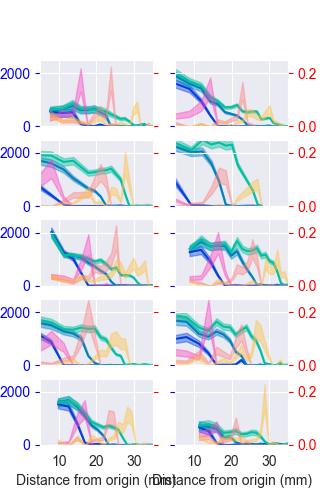

In [35]:
cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")
suffix = ""
suffix = "-new"
max_indexes = {int(plate.split('_')[0]) : 20 for plate in plates}
ncols =2
fig,axs = gridplot(len(plates),ncols = ncols,subh = height,subw = width,sharex=True,sharey=True)
for j,ax in enumerate(axs):
    if j<len(plates):
        ax2 = ax.twinx()
        plate = plates[j]
        plate = int(plate.split('_')[0])
        table = time_plate_info.loc[time_plate_info["Plate"]==plate]
        table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

        # table = table.dropna()
        ts = list(table['timestep'])
        table = table.set_index('timestep',drop=False)
        table_err = table_err.set_index('timestep',drop=False)

        ts = list(table.index)
        ts.sort()
        dic = {}
        ax.axis([5,35,0,2500])

        shift = shifts[plate]
        i0 = shift
        timesteps_select = []
        for delta in [0,30,60]:
            target_value = table["time_since_begin"].iloc[i0] + timedelta(hours=delta)
            differences = abs(table["time_since_begin"] - target_value)
            closest_index = differences.idxmin()
            closest_row = table.loc[closest_index]
            print(differences[closest_index])
            timesteps_select.append(closest_row["timestep"])
        for i,t in enumerate(timesteps_select):
     #     ax.set_yscale("log")

            maxL = np.sqrt(1900)
            X = np.linspace(0,maxL,100)
            incr = 100
            def density(x,suffix = ''):
                area = x**2
                index = int(area//incr)
                column = f"ring_density_incr-100_index-{index}{suffix}"
                if len(suffix) == 0:
                    return(float(table[column][t]))
                else:
                    return(float(table_err[column][t]))
            xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
            yvalues = [density(x,suffix) for x in xvalues]
            xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if not(np.isnan(y))])

            dic[t] = {}
            dic[t]['distance_origin'] = xvalues
            dic[t]['ring_density'] = yvalues
            xvalues = np.array(xvalues)
            yvalues = np.array(yvalues) 
            X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
            Y = yvalues
            line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
            scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i+1)/4),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
            table = table.sort_values('area_sep_comp')
            xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
            err = 0*ys + 160*ys/np.max(ys)
            ax.fill_between(xs, ys-err, ys+err,color=cmap((i+1)/4),alpha = 0.4)
            xs = np.linspace(np.min(X),np.max(X),1000)
            ts = [table['time_since_begin_h'][t] for x in xs]
            xt = np.array((xs,ts))
            def density(x):
                area = x**2
                index = int(area//incr)
                column = f"ring_active_tips_density_incr-100_index-{index}"
                return(float(table[column][t]))
            xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
            yvalues = [density(x) for x in xvalues]

            xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if not(np.isnan(y))])
            dic[t]['tip_density'] = yvalues
            xvalues = np.array(xvalues)
            yvalues = np.array(yvalues) 
            X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
            Y = yvalues
            xs = np.linspace(np.min(X),np.max(X),1000)
            ts = [table['time_since_begin_h'][t] for x in xs]
            xt = np.array((xs,ts))
            xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
            err = abs(ys)/4
            ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i+1)/4),alpha = 0.4)
            if j//ncols == len(plates)//ncols-1:
                ax.set_xlabel('Distance from origin (mm)')
            ax2.set_ylim((0,0.25))
            if j%ncols < ncols-1:
                ax2.set_yticklabels([])
            ax.tick_params(axis='y', colors='blue')
            ax2.tick_params(axis='y', colors='red')
            right = 0.90
            top = 0.90
            fontsize = 10


In [36]:
suffix = "-new"



C:\Users\coren\AppData\Local\Temp\ipykernel_22552\283088842.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = mpl.cm.get_cmap("spring")
C:\Users\coren\AppData\Local\Temp\ipykernel_22552\283088842.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = mpl.cm.get_cmap("winter")
C:\Users\coren\AppData\Local\pypoetry\Cache\virtualenvs\amftrack-YdvNN67V-py3.11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\coren\Documents\PhD\paper\travelling_wave\AMFTravellingWave\amftrack\pipeline\final_analysis\density_wave.py:55: Runt

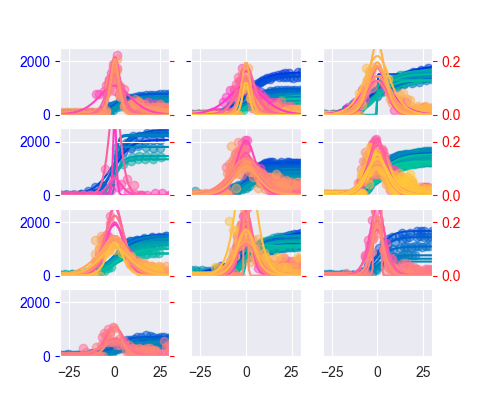

In [37]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
maxi = 15
max_area=50
Csstips = {}
Css = {}

ncols =3
lambsstips = {}
fig,axs = gridplot(len(plates),ncols = ncols,subh = height,subw = width,sharex=True,sharey=True)
dss = {}
dssC = {}

for j,ax in enumerate(axs):
    if j<len(plates):
    # if j==2:
        
        ax2 = ax.twinx()
        plate = plates[j]
        plate = int(plate.split('_')[0])
        timesteps= range(0,timestep[plate]) 
        popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
        t0 = popt_f[-1]/popt_f[0]
        table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
        table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]
        table = table.set_index('timestep',drop=False)
        table_err = table_err.set_index('timestep',drop=False)
        shift = shifts[plate]
        timesteps = table.loc[table['time_since_begin_h'].between(t0+shift,t0+shift+110)]['timestep']
        timestep_max =np.max(timesteps)
        table = table.loc[table["timestep"]<=timestep_max]
        table = table.set_index("timestep")
        ts = []
        ys = []
        ys2 = []
        Cs = []
        Cserror = []
        t0serror = []
        lambs = []
        indexes = []
        t0s = []
        ds = []
        dsC = []
        Cstips = []
        lambstip = []

        for index in range(1, maxi):
            column = f"ring_density_incr-100_index-{index}{suffix}"
            column2 = f"ring_active_tips_density_incr-100_index-{index}"
            if len(suffix)>0:
                table[column] = table_err[column]
            area = np.sqrt(table["area_sep_comp"][0] + 100 * index)

            sorted_column = table.sort_values(by=column,ascending=True)
            # if len(sorted_column.loc[sorted_column[column] >= 400])>2:
            if len(sorted_column.loc[sorted_column[column] >= 400])>3:


                start = sorted_column.loc[sorted_column[column] >= 400]["time_since_begin"].iloc[2]
                select = table.loc[(table["time_since_begin"]/pd.Timedelta(hours=1)).between(start/pd.Timedelta(hours=1)-50,start/pd.Timedelta(hours=1)+50)]
                select = select.loc[((select["time_since_begin"]>=start)&(select[column]>=400)) | (select["time_since_begin"]<start)&(select[column]<=400)].copy()
                select[f"time_since_begin_{index}"] = (
                    select["time_since_begin"] - start
                )/pd.Timedelta(hours = 1)

                selection_fit = select
                xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]


                popt0, pcov = curve_fit(
                    S,
                    xis,
                    yis,
                    bounds=([0, 0, -np.inf], 3 * [np.inf]),
                    p0=[1, 1000, 0],
                )
                lamb, C, t0 = list(popt0)
                select[f"time_since_begin_{index}"] = select[f"time_since_begin_{index}"] - t0

                ax.scatter(
                    select[f"time_since_begin_{index}"],
                    select[column],
                    alpha=0.5,
                    color=cmap2(area / max_area),
                )

                xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
                data = np.array((xis,yis))
                def statistic(x,y):
                    try:
                        popt0, pcov = curve_fit(
                        S,
                        x,
                        y,
                        bounds=([0, 0, -np.inf], 3 * [np.inf]),
                        p0=[1, 1, 0],
                    )
                        return(popt0[2])
                    except:
                        return(C)
                xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
                data = np.array((xis,yis))
                t0s.append(t0+start/pd.Timedelta(hours=1))

                Cs.append(C)
                dsC.append(int(area / np.sqrt((np.pi / 2))))

                lambs.append(lamb)
                indexes.append(index)
                x = np.linspace(-50, 50, 100)
                ax.plot(
                    x,
                    S(x + t0, lamb, C, t0),
                    color=cmap2(area / max_area),
                    label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
                )
                try:
                    popt1, _ = curve_fit(
                        dS,
                        selection_fit[f"time_since_begin_{index}"],
                        selection_fit[column2],
                        bounds=([0, 0, -np.inf], 3 * [np.inf]),
                        p0=[0.2, 0.5, 0],
                    )
                    lamb, C, t1 = list(popt1)
                    if lamb>0.15:
                        Cstips.append(C)
                        lambstip.append(lamb)
                        ds.append(int(area / np.sqrt((np.pi / 2))))

                        ax2.scatter(
                            select[f"time_since_begin_{index}"]-t1,
                            select[column2],
                            alpha=0.5,
                            color=cmap1(area / max_area),
                        )
                        ax2.plot(
                            x,
                            dS(x +t1, lamb, C, t1),
                            color=cmap1(area / max_area),
                            label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
                        )
                except (RuntimeError, ValueError) as e:
                    pass

        ax2.set_xlim((-30, 30))
        ax2.set_ylim((0, 0.25))
        ax.set_ylim((0, 2500))
        ax.tick_params(axis="y", colors="blue")
        ax2.tick_params(axis="y", colors="red")
        if j%ncols < ncols-1:
            ax2.set_yticklabels([])
        Csstips[plate] = Cstips
        Css[plate] = Cs

        lambsstips[plate] = lambstip
        dss[plate] = ds
        dssC[plate] = dsC


In [38]:
plates

['52_20220707',
 '56_20220701',
 '59_20201126',
 '76_20210108',
 '84_20220621',
 '94_20201123',
 '152_20201224',
 '792_20210915',
 '1076_20220511',
 '941_20220404']

In [39]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

(0.0, 2500.0)

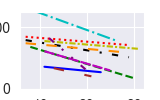

In [40]:
fig,ax = plt.subplots(figsize=(width,height))
# Define a list of line styles
line_styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5)), (0, (5, 5)), (0, (3, 5, 1, 5, 1, 5)),
              (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 10))]

# Define a list of line colors
line_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange', 'purple', 'brown', 'teal', 'pink']

def statistic(ds,Cs):
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    color = plt.gca().lines[-1].get_color()
    ax.plot(ds,np.array(ds)*a+b,color = color, alpha = 0.01)
    return(a)

tot_ds = []
tot_Cs=[]
for j,plate in enumerate(plates):
    plate = int(plate.split('_')[0])
    Cs = Css[plate]
    ds = dssC[plate]
    tot_ds+=ds
    tot_Cs+=Cs
    # ax.plot(ds,Cs,alpha = 0.2,color = line_colors[j])
    
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(ds,np.array(ds)*a+b,label=plate,linestyle = line_styles[j],color = line_colors[j])
    data = np.array((ds,Cs))
df = pd.DataFrame((tot_ds,tot_Cs)).transpose()
df.columns = ('distance','saturation density')
data = np.array((tot_ds,tot_Cs))
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density \n ($\mu m.mm^{-2}$)')
# ax.set_ylim(0,1000)

# plt.tight_layout()
# plt.savefig(f'Figure/FigureS1Bsubset.svg')    
ax.set_ylim(0,2500)
# plt.savefig(os.path.join(path_figure,'FigureS2D.pdf'), transparent=True, bbox_inches='tight')


Text(0, 0.5, 'peak value ($mm^{-2}$)')

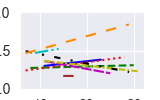

In [41]:
fig, ax = plt.subplots(figsize=(width,height))

for j,plate in enumerate(plates):
    plate = int(plate.split('_')[0])
    Cstips = np.array(Csstips[plate])/2
    if len(Cstips)>1:
        ds = dss[plate]
        # ax.scatter(ds,Cstips)
        x = np.array(ds)
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(Cstips,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x,x*a+b,linestyle = line_styles[j],color = line_colors[j])
ax.set_ylim(0,1)
ax.set_xlabel('distance from origin (mm)')

ax.set_ylabel("peak value ($mm^{-2}$)")


In [43]:

all_analysis_folders = get_analysis_folders()

analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

In [44]:
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)

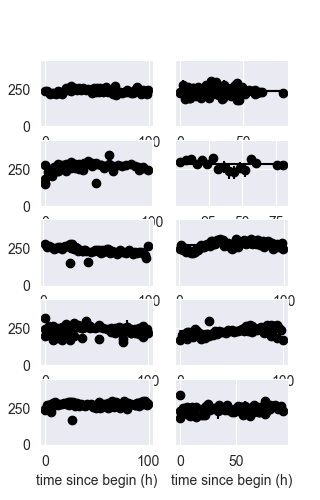

In [51]:
width = 1.6
height = 1
ncols = 2
fig,axs = gridplot(len(plates),ncols = ncols,subh = height,subw = width)
ax_list = list(axs)
maxi = 100
replicate_dfs = []
for j in range(len(plates)):
    replicate_data = []
    plate_id = plates[j]
    plate = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

    data,dy,select_movements = get_average_time_data(int(plate_id),time_hypha_info,2)
    hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
    if len(hyphae_hull)>0:
        label = 'hull pusher'
        for t in range(1,min(len(time_hypha_plate['timestep'].unique())-1,maxi)):
            select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
            select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
            select = select.loc[select['speed'].between(150,350)]
            if len(select)>0:
                time = select['time_since_emergence'].iloc[0]
                if time<=100:
                    ax.scatter(select['time_since_emergence'].iloc[0],np.mean(select["speed"]),color='black')
                    ax.errorbar(select['time_since_emergence'].iloc[0],np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
                    replicate_data.append({
                        # "Plate": plate_id,
                        "Time": select['time_since_emergence'].iloc[0],
                        "Replicates": len(select),
                        # "Mean Speed": np.mean(select["speed"]),
                    })
                    label = None
                    hull_speeds.append(np.mean(select["speed"]))
                    hull_time.append(select['time_since_emergence'].iloc[0])
        ax.set_ylim(0,450)
        if j//ncols == len(plates)//ncols-1:
            ax.set_xlabel('time since begin (h)')
        if j%ncols == 0:
            ax.set_ylabel('speed ($\mu m.h^{-1}$)') 
        if j%ncols !=0:
            ax.set_yticklabels([])
        ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
                color="black",
                label= f'mean hull pusher speed {int(np.nanmean(hull_speeds))}$\pm${int(2*np.nanstd(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')

    replicate_df = pd.DataFrame(replicate_data)
    replicate_dfs.append(replicate_df)

In [54]:
import pandas as pd

# Add a "Plate" column to each DataFrame and concatenate them
for idx, df in enumerate(replicate_dfs):
    df['Plate'] = f"Plate {idx + 1}"  # Add plate info

# Combine all DataFrames into one
combined_df = pd.concat(replicate_dfs, ignore_index=True)

combined_df.to_clipboard()
